### Linear Regression and ML Model for AIS

Import libraries

In [1]:
import kagglehub

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import networkx as nx

Import AIS Data (starting with one day's worth for now)

In [2]:
# Download latest version
path = kagglehub.dataset_download("marsalanakhtar/ais-data-for-ships")

print("Path to dataset files:", path)
ais_data = pd.read_csv(f"{path}/AIS_2022_03_31.csv")

Path to dataset files: C:\Users\DJBird\.cache\kagglehub\datasets\marsalanakhtar\ais-data-for-ships\versions\1


In [3]:
ais_data.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,367702220,2022-03-31T00:00:01,29.78763,-95.08070,0.1,226.5,340.0,JOE B WARD,NaN,WDI4808,31.0,12.0,21.0,8.0,NaN,57.0,A
1,671226100,2022-03-31T00:00:01,25.77626,-80.20320,3.2,143.7,511.0,RELIANCE II,IMO9221322,5VHS7,79.0,0.0,52.0,12.0,2.5,70.0,A
2,367767250,2022-03-31T00:00:01,29.31623,-94.78829,4.5,228.1,511.0,GLEN K,NaN,WDJ3358,52.0,0.0,0.0,0.0,0.0,52.0,A
3,338327436,2022-03-31T00:00:03,47.29634,-122.42233,0.0,360.0,511.0,COOL KAT,IMO0000000,NaN,36.0,NaN,15.0,3.0,NaN,NaN,B
4,367452810,2022-03-31T00:00:06,29.32824,-94.77391,2.6,319.2,511.0,JOHN W JOHNSON,IMO9602344,WDF4516,60.0,0.0,80.0,19.0,3.0,60.0,A


In [4]:
ais_data.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')

In [5]:
len(ais_data)

7167046

In [6]:
len(ais_data['MMSI'].unique())

15831

Define AIS vessel type codes

In [7]:
ais_vessel_types = {
1: "Reserved for future use",
2: "Reserved for future use",
3: "Reserved for future use",
4: "Reserved for future use",
5: "Reserved for future use",
6: "Reserved for future use",
7: "Reserved for future use",
8: "Reserved for future use",
9: "Reserved for future use",
10: "Reserved for future use",
11: "Reserved for future use",
12: "Reserved for future use",
13: "Reserved for future use",
14: "Reserved for future use",
15: "Reserved for future use",
16: "Reserved for future use",
17: "Reserved for future use",
18: "Reserved for future use",
19: "Reserved for future use",
20: "Wing in ground (WIG), all ships of this type",
21: "Wing in ground (WIG), Hazardous category A",
22: "Wing in ground (WIG), Hazardous category B",
23: "Wing in ground (WIG), Hazardous category C",
24: "Wing in ground (WIG), Hazardous category D",
25: "Wing in ground (WIG), Reserved for future use",
26: "Wing in ground (WIG), Reserved for future use",
27: "Wing in ground (WIG), Reserved for future use",
28: "Wing in ground (WIG), Reserved for future use",
29: "Wing in ground (WIG), Reserved for future use",
30: "Fishing",
31: "Towing",
32: "Towing: length exceeds 200m or breadth exceeds 25m",
33: "Dredging or underwater ops",
34: "Diving ops",
35: "Military ops",
36: "Sailing",
37: "Pleasure Craft",
38: "Reserved",
39: "Reserved",
40: "High speed craft (HSC), all ships of this type",
41: "High speed craft (HSC), Hazardous category A",
42: "High speed craft (HSC), Hazardous category B",
43: "High speed craft (HSC), Hazardous category C",
44: "High speed craft (HSC), Hazardous category D",
45: "High speed craft (HSC), Reserved for future use",
46: "High speed craft (HSC), Reserved for future use",
47: "High speed craft (HSC), Reserved for future use",
48: "High speed craft (HSC), Reserved for future use",
49: "High speed craft (HSC), No additional information",
50: "Pilot Vessel",
51: "Search and Rescue vessel",
52: "Tug",
53: "Port Tender",
54: "Anti-pollution equipment",
55: "Law Enforcement",
56: "Spare - Local Vessel",
57: "Spare - Local Vessel",
58: "Medical Transport",
59: "Noncombatant ship according to RR Resolution No. 18",
60: "Passenger, all ships of this type",
61: "Passenger, Hazardous category A",
62: "Passenger, Hazardous category B",
63: "Passenger, Hazardous category C",
64: "Passenger, Hazardous category D",
65: "Passenger, Reserved for future use",
66: "Passenger, Reserved for future use",
67: "Passenger, Reserved for future use",
68: "Passenger, Reserved for future use",
69: "Passenger, No additional information",
70: "Cargo, all ships of this type",
71: "Cargo, Hazardous category A",
72: "Cargo, Hazardous category B",
73: "Cargo, Hazardous category C",
74: "Cargo, Hazardous category D",
75: "Cargo, Reserved for future use",
76: "Cargo, Reserved for future use",
77: "Cargo, Reserved for future use",
78: "Cargo, Reserved for future use",
79: "Cargo, No additional information",
80: "Tanker, all ships of this type",
81: "Tanker, Hazardous category A",
82: "Tanker, Hazardous category B",
83: "Tanker, Hazardous category C",
84: "Tanker, Hazardous category D",
85: "Tanker, Reserved for future use",
86: "Tanker, Reserved for future use",
87: "Tanker, Reserved for future use",
88: "Tanker, Reserved for future use",
89: "Tanker, No additional information",
90: "Other Type, all ships of this type",
91: "Other Type, Hazardous category A",
92: "Other Type, Hazardous category B",
93: "Other Type, Hazardous category C",
94: "Other Type, Hazardous category D",
95: "Other Type, Reserved for future use",
96: "Other Type, Reserved for future use",
97: "Other Type, Reserved for future use",
98: "Other Type, Reserved for future use",
99: "Other Type, no additional information"
}


def get_vessel_type(code):
    """
    Retrieves the vessel type description from an AIS code.
    """
    return ais_vessel_types.get(code, "Unknown or Reserved Code")

In [8]:
ais_data['VesselType_Str'] = ais_data['VesselType'].apply(get_vessel_type)

In [9]:
ais_data['VesselType_Str'].value_counts()

VesselType_Str
Towing                                                 2560218
Pleasure Craft                                         1283684
Cargo, all ships of this type                           540352
Passenger, all ships of this type                       530078
Other Type, all ships of this type                      521006
Fishing                                                 373080
Sailing                                                 277918
Tanker, all ships of this type                          249794
Tug                                                     225682
Spare - Local Vessel                                    161652
Unknown or Reserved Code                                 95423
Pilot Vessel                                             46005
Dredging or underwater ops                               40508
Other Type, no additional information                    38634
Cargo, Hazardous category A                              29129
Cargo, No additional information        

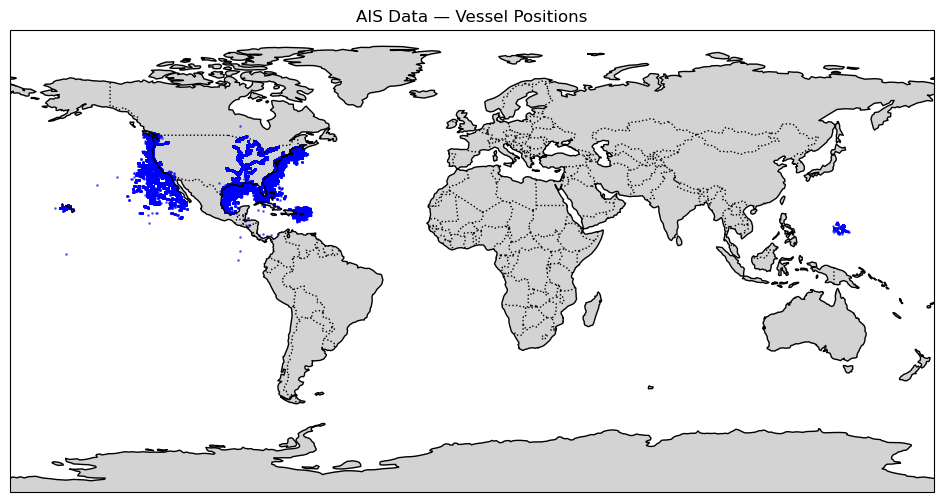

In [10]:
# Create map
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and land
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()

# Plot points
ax.scatter(ais_data['LON'], ais_data['LAT'], s=1, c='blue', alpha=0.5, transform=ccrs.PlateCarree())

plt.title("AIS Data — Vessel Positions")
plt.show()

### Linear Regression

In [11]:
import matplotlib.pyplot as plt
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [12]:
ais_data.describe()

,MMSI,LAT,LON,SOG,COG,Heading,VesselType,Status,Length,Width,Draft,Cargo
count,7.167046e+06,7.167046e+06,7.167046e+06,7.167046e+06,7.167046e+06,7.167046e+06,7.166229e+06,5.538308e+06,6.728850e+06,5.992969e+06,2.705725e+06,5.542099e+06
mean,3.689320e+08,3.431434e+01,-9.410481e+01,2.191576e+00,2.144709e+02,3.513175e+02,4.554817e+01,4.270637e+00,5.458952e+01,1.189576e+01,5.383081e+00,5.152391e+01
std,6.222735e+07,7.546518e+00,1.923752e+01,6.920378e+00,1.136973e+02,1.795198e+02,2.055181e+01,5.574530e+00,7.325289e+01,1.044505e+01,4.315218e+00,2.133361e+01
min,0.000000e+00,4.608300e-01,-1.626541e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.668669e+08,2.945311e+01,-9.714705e+01,0.000000e+00,1.230000e+02,1.860000e+02,3.100000e+01,0.000000e+00,1.700000e+01,6.000000e+00,2.600000e+00,3.200000e+01
50%,3.674445e+08,3.067654e+01,-9.030416e+01,0.000000e+00,2.339000e+02,5.110000e+02,3.700000e+01,0.000000e+00,2.400000e+01,8.000000e+00,4.000000e+00,5.200000e+01
75%,3.680120e+08,3.988592e+01,-8.047684e+01,7.000000e-01,3.137000e+02,5.110000e+02,6.000000e+01,1.100000e+01,4.400000e+01,1.200000e+01,8.200000e+00,6.000000e+01
max,1.072211e+09,5.257111e+01,1.469341e+02,1.023000e+02,3.888000e+02,5.110000e+02,2.550000e+02,1.500000e+01,4.760000e+02,1.200000e+02,2.550000e+01,2.000000e+02


In [13]:
ais_data.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass', 'VesselType_Str'],
      dtype='object')

In [14]:
predictors = ais_data[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG']].dropna()

predictors = predictors.sort_values(['MMSI', 'BaseDateTime'])

ais_data['LAT_next'] = ais_data.groupby('MMSI')['LAT'].shift(-1)
ais_data = ais_data.dropna()

# Handle circular COG
ais_data['COG_sin'] = np.sin(np.deg2rad(ais_data['COG']))
ais_data['COG_cos'] = np.cos(np.deg2rad(ais_data['COG']))

# Define X and y
X = ais_data[['LAT', 'SOG', 'COG_sin', 'COG_cos']]
y = ais_data['LAT_next']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=111
)

# Add intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit linear regression
model = sm.OLS(y_train, X_train)
results = model.fit()


In [15]:
# Output
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               LAT_next   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.237e+09
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:33:03   Log-Likelihood:             8.5947e+05
No. Observations:             1580444   AIC:                        -1.719e+06
Df Residuals:                 1580439   BIC:                        -1.719e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.001      9.369      0.0

C:\Users\DJBird\AppData\Local\Temp\ipykernel_45828\3565024276.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
C:\Users\DJBird\AppData\Local\Temp\ipykernel_45828\3565024276.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1],


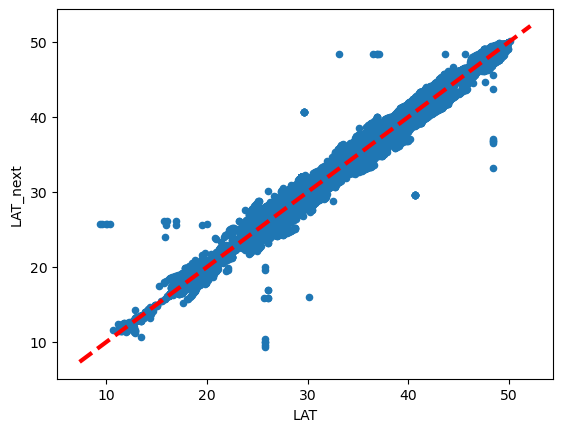

In [16]:
# Defining Functions
def abline(ax, b, m):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim)

def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = ais_data.plot.scatter('LAT', 'LAT_next')
abline(ax,
 results.params[0],
 results.params[1],
 'r--',
 linewidth=3)

In [17]:
ais_data['LON_next'] = ais_data.groupby('MMSI')['LON'].shift(-1)
ais_data = ais_data.dropna(subset = ['LON_next'])

X = ais_data[['LAT','SOG','COG_sin','COG_cos']]
y_lon = ais_data['LON_next']

X_train, X_test, ylon_train, ylon_test = train_test_split(
    X, y_lon, test_size=0.2, random_state=111
)

X_train = sm.add_constant(X_train)
model_lon = sm.OLS(ylon_train, X_train).fit()

print(model_lon.summary())


                            OLS Regression Results                            
Dep. Variable:               LON_next   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                 5.562e+04
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:33:11   Log-Likelihood:            -6.8771e+06
No. Observations:             1577584   AIC:                         1.375e+07
Df Residuals:                 1577579   BIC:                         1.375e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -61.6294      0.068   -910.720      0.0

C:\Users\DJBird\AppData\Local\Temp\ipykernel_45828\247475968.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
C:\Users\DJBird\AppData\Local\Temp\ipykernel_45828\247475968.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1],


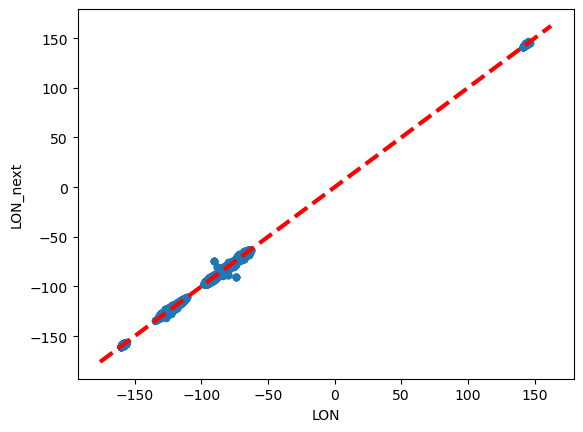

In [18]:
ax = ais_data.plot.scatter('LON', 'LON_next')
abline(ax,
 results.params[0],
 results.params[1],
 'r--',
 linewidth=3)

In [19]:
def create_encounter_dict(df, time_bin_minutes=10, lat_col='LAT', lon_col='LON', mmsi_col='MMSI', radius_deg=0.01):
    """
    Returns a dictionary: {MMSI: [list of MMSIs encountered in same space-time bucket]}
    
    Parameters:
        df: pandas DataFrame with columns [MMSI, BaseDateTime, LAT, LON]
        time_bin_minutes: size of time bucket
        radius_deg: spatial tolerance in degrees (~0.01 ≈ 1 km)
    """
    df = df.copy()
    time_col = 'BaseDateTime'
    df[time_col] = pd.to_datetime(df[time_col], utc=True)

    # Create time bins
    df['time_bin'] = (df[time_col].astype('int64') // (time_bin_minutes*60*10**9))     # converts each timestamp into its integer representation in nanoseconds since the Unix epoch (1970-01-01T00:00:00Z).

    encounter_dict = dict()
    
    # Initialize empty list for each MMSI
    for mmsi in df[mmsi_col].unique():
        encounter_dict[mmsi] = set()
    
    # Group by time_bin for efficiency
    for _, group in df.groupby('time_bin'):                                         # Grouping by time bin.
        coords = group[[lat_col, lon_col]].to_numpy()
        mmsis = group[mmsi_col].to_numpy()
        n = len(group)
        # Compare each pair (i,j) in the time bin
        for i in range(n):
            lat_i, lon_i = coords[i]
            mmsi_i = mmsis[i]
            for j in range(i+1, n):
                lat_j, lon_j = coords[j]
                mmsi_j = mmsis[j]
                # check if within spatial radius
                if abs(lat_i - lat_j) <= radius_deg and abs(lon_i - lon_j) <= radius_deg:
                    encounter_dict[mmsi_i].add(mmsi_j)
                    encounter_dict[mmsi_j].add(mmsi_i)
    
    # Convert sets to lists
    encounter_dict = {k: list(v) for k,v in encounter_dict.items()}
    return encounter_dict

In [20]:
encounter_dict = create_encounter_dict(ais_data[:100])

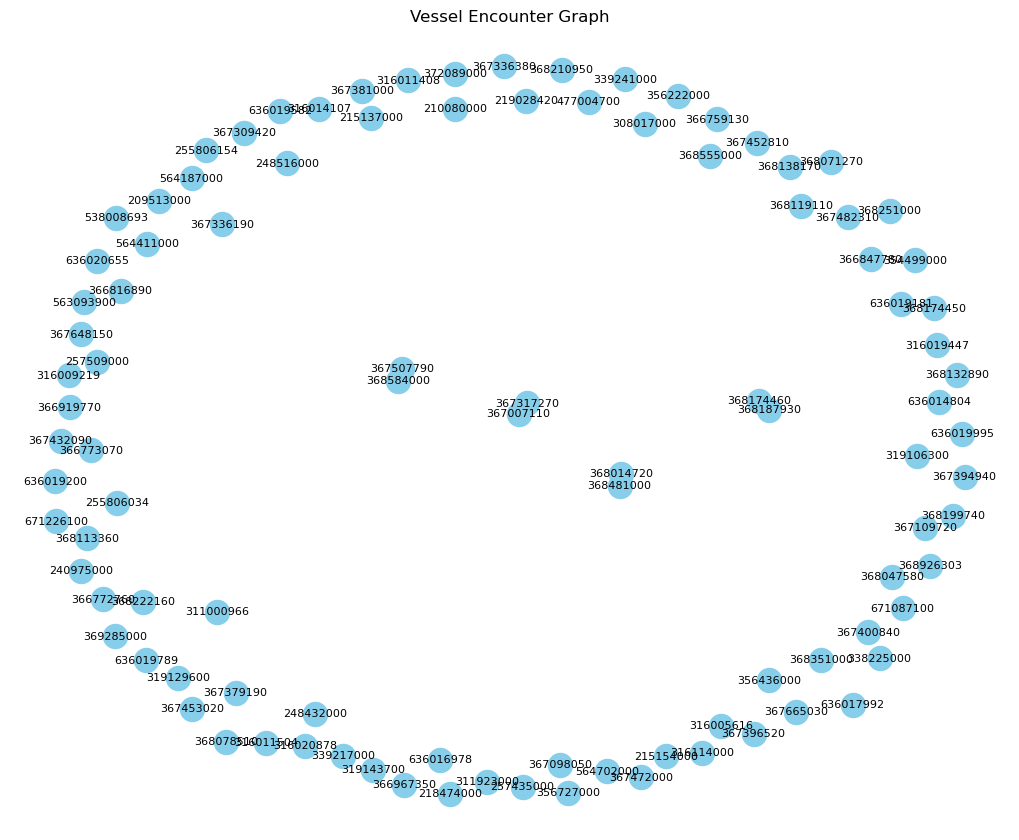

In [21]:
G = nx.Graph()

# Add all MMSIs as nodes (isolated nodes included)
G.add_nodes_from(encounter_dict.keys())

# Add edges (ignoring self-loops)
for mmsi, neighbors in encounter_dict.items():
    for neighbor in neighbors:
        if neighbor != mmsi:   # ignore loops
            G.add_edge(mmsi, neighbor)


plt.figure(figsize=(10, 8))
nx.draw(G, 
        with_labels=True,       # show MMSI labels
        node_size=300, 
        node_color='skyblue', 
        edge_color='gray', 
        font_size=8)
plt.title("Vessel Encounter Graph")
plt.show()

In [22]:
import pickle

# Save
with open("CapstoneAISgraph.pkl", "wb") as f:
    pickle.dump(G,f)

In [23]:
ais_data.to_json("ais_data.json", orient = "records", lines = True)

In [24]:
# Static and dynamic columns
static_cols = [
    "VesselName", "IMO", "CallSign", "VesselType", "Status",
    "Length", "Width", "Draft", "Cargo", "TransceiverClass", "VesselType_Str"
]
dynamic_cols = ["LAT", "LON", "SOG", "COG", "Heading"]

In [25]:
# Build the aggregation dictionary using *named aggregation* correctly
agg_dict = {}

# Static columns → just take the first non-null value
for col in static_cols:
    agg_dict[col] = (col, "first")

# Dynamic columns → compute stats
for col in dynamic_cols:
    agg_dict[f"{col}_mean"] = (col, "mean")
    agg_dict[f"{col}_min"] = (col, "min")
    agg_dict[f"{col}_max"] = (col, "max")
    agg_dict[f"{col}_std"] = (col, "std")

# BaseDateTime → only min and max
agg_dict["BaseDateTime_min"] = ("BaseDateTime", "min")
agg_dict["BaseDateTime_max"] = ("BaseDateTime", "max")

In [26]:
# Group and aggregate
df_summary = (
    ais_data.groupby("MMSI")
           .agg(**agg_dict)
           .reset_index()
)

In [27]:
# Make sure BaseDateTime is a datetime type
ais_data["BaseDateTime"] = pd.to_datetime(ais_data["BaseDateTime"])

# Sort so we can compute differences correctly
ais_data = ais_data.sort_values(["MMSI", "BaseDateTime"])

# Compute time differences (in seconds) between consecutive messages per MMSI
ais_data["time_diff_sec"] = (
    ais_data.groupby("MMSI")["BaseDateTime"]
           .diff()
           .dt.total_seconds()
)

# Now average those differences per vessel
avg_gap = (
    ais_data.groupby("MMSI")["time_diff_sec"]
           .mean()
           .reset_index(name="avg_time_gap_sec")
)

C:\Users\DJBird\AppData\Local\Temp\ipykernel_45828\1248610896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ais_data["BaseDateTime"] = pd.to_datetime(ais_data["BaseDateTime"])


In [28]:
df_summary = df_summary.merge(avg_gap, on="MMSI", how="left")

In [29]:
ais_data.groupby("MMSI")["time_diff_sec"].agg(["mean", "median", "max"])

,mean,median,max
MMSI,,,
111,735.444444,183.0,14040.0
368926,206.981912,180.0,1261.0
1056261,77.540395,70.0,3211.0
3791472,76.607908,70.0,1780.0
205086000,247.455331,181.0,3775.0
...,...,...,...
671947000,5250.416667,901.0,17998.0
671960000,162.464896,72.0,9078.0
671969100,74.687175,70.0,3219.0


In [30]:
df_summary.head()

,MMSI,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,...,COG_min,COG_max,COG_std,Heading_mean,Heading_min,Heading_max,Heading_std,BaseDateTime_min,BaseDateTime_max,avg_time_gap_sec
0,111,BOOMVANG,IMO0000001,EB643,90.0,5.0,47.0,35.0,0.0,90.0,...,19.2,354.6,90.183027,511.000000,511.0,511.0,0.000000,2022-03-31T00:02:32,2022-03-31T23:56:39,735.444444
1,368926,WARSHIP 20,IMO0004371,LCS 20,35.0,5.0,128.0,32.0,0.0,35.0,...,0.5,359.9,102.170698,235.000000,235.0,235.0,0.000000,2022-03-31T01:44:34,2022-03-31T23:59:36,206.981912
2,1056261,CHAMPAGNE CHER,IMO1056261,WDC6418,10.0,0.0,35.0,8.0,2.5,10.0,...,0.2,359.1,92.057574,511.000000,511.0,511.0,0.000000,2022-03-31T00:00:17,2022-03-31T23:59:57,77.540395
3,3791472,LUCIUS SPAR,IMO1108561,WQXP40,80.0,15.0,0.0,0.0,0.0,80.0,...,0.3,359.3,96.949941,1.000000,1.0,1.0,0.000000,2022-03-31T11:04:31,2022-03-31T23:59:32,76.607908
4,205086000,DORIS,IMO9877781,ONKY,80.0,1.0,336.0,60.0,11.0,80.0,...,1.6,359.9,115.572619,124.318966,1.0,358.0,61.886891,2022-03-31T00:07:17,2022-03-31T23:58:24,247.455331


In [31]:
# numeric columns (everything except identifiers and VesselType_Str)
numeric_cols = df_summary.select_dtypes(include=[np.number]).columns.tolist()

# remove MMSI if present
numeric_cols = [c for c in numeric_cols if c != "MMSI"]

# categorical target
target_col = "VesselType_Str"


In [32]:
df_summary.groupby(target_col)[numeric_cols].mean().T


VesselType_Str,Anti-pollution equipment,"Cargo, Hazardous category A","Cargo, Hazardous category B","Cargo, Hazardous category C","Cargo, Hazardous category D","Cargo, No additional information","Cargo, Reserved for future use","Cargo, all ships of this type",Diving ops,Dredging or underwater ops,...,"Tanker, Hazardous category D","Tanker, No additional information","Tanker, all ships of this type",Towing,Towing: length exceeds 200m or breadth exceeds 25m,Tug,Unknown or Reserved Code,"Wing in ground (WIG), Hazardous category C","Wing in ground (WIG), Reserved for future use","Wing in ground (WIG), all ships of this type"
VesselType,54.000000,71.000000,72.000000,73.000000,74.000000,79.000000,75.500000,70.000000,34.000000,33.000000,...,84.000000,89.000000,80.000000,31.000000,32.000000,52.000000,0.000000,23.000000,27.000000,20.000000
Status,5.000000,1.666667,2.200000,0.000000,2.045455,1.904762,5.000000,2.061523,2.000000,6.857143,...,1.666667,0.777778,1.511931,3.204918,2.500000,4.655172,5.000000,0.000000,2.500000,7.600000
Length,25.000000,294.500000,215.000000,334.000000,298.590909,190.214286,90.000000,209.301758,57.333333,45.428571,...,234.166667,208.222222,204.177874,32.472131,25.166667,31.387931,93.031250,20.000000,78.500000,55.800000
Width,10.000000,40.454545,31.400000,48.000000,42.227273,27.904762,15.000000,30.822266,13.333333,11.142857,...,36.666667,35.722222,34.134490,9.849180,8.333333,9.991379,19.968750,8.000000,26.500000,13.600000
Draft,2.500000,11.746970,9.510000,13.100000,11.868182,8.661905,3.900000,10.367969,3.733333,2.442857,...,8.150000,9.030556,11.769197,4.143279,3.250000,3.498276,5.162500,4.000000,4.900000,2.300000
Cargo,54.000000,70.954545,71.800000,73.000000,73.681818,78.785714,75.500000,69.772461,34.000000,33.000000,...,84.000000,88.527778,80.572668,44.291803,39.500000,52.810345,1.781250,23.000000,27.000000,20.000000
LAT_mean,49.169591,35.420925,30.999180,40.397428,35.098996,30.471511,32.534460,33.527736,33.668661,36.717532,...,27.341203,29.140741,29.422570,35.485366,26.884623,32.796560,29.674584,30.207032,28.775973,29.081462
LAT_min,49.169555,35.033025,30.814845,39.468740,34.664192,30.118840,32.534405,33.157014,33.616107,36.717106,...,27.036862,28.579767,29.005544,35.379985,26.354592,32.726604,29.226129,30.141130,28.183335,29.071090
LAT_max,49.169640,35.656397,31.166277,40.678760,35.425430,30.852818,32.534525,33.842486,33.671910,36.717741,...,27.622107,29.621272,29.771963,35.589699,27.138478,32.864303,29.744831,30.426030,29.048340,29.086922
LAT_std,0.000016,0.170027,0.104099,0.335050,0.217435,0.204404,0.000019,0.188921,0.010374,0.000085,...,0.168134,0.296648,0.220682,0.059575,0.180235,0.042215,0.110561,0.070516,0.305843,0.005171


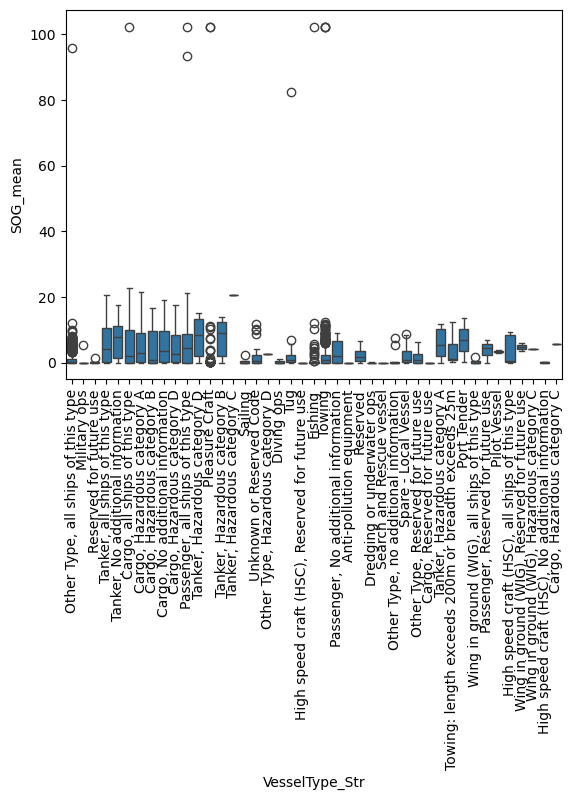

In [33]:
import seaborn as sns
sns.boxplot(x=target_col, y="SOG_mean", data=df_summary)
plt.xticks(rotation=90)
plt.show()

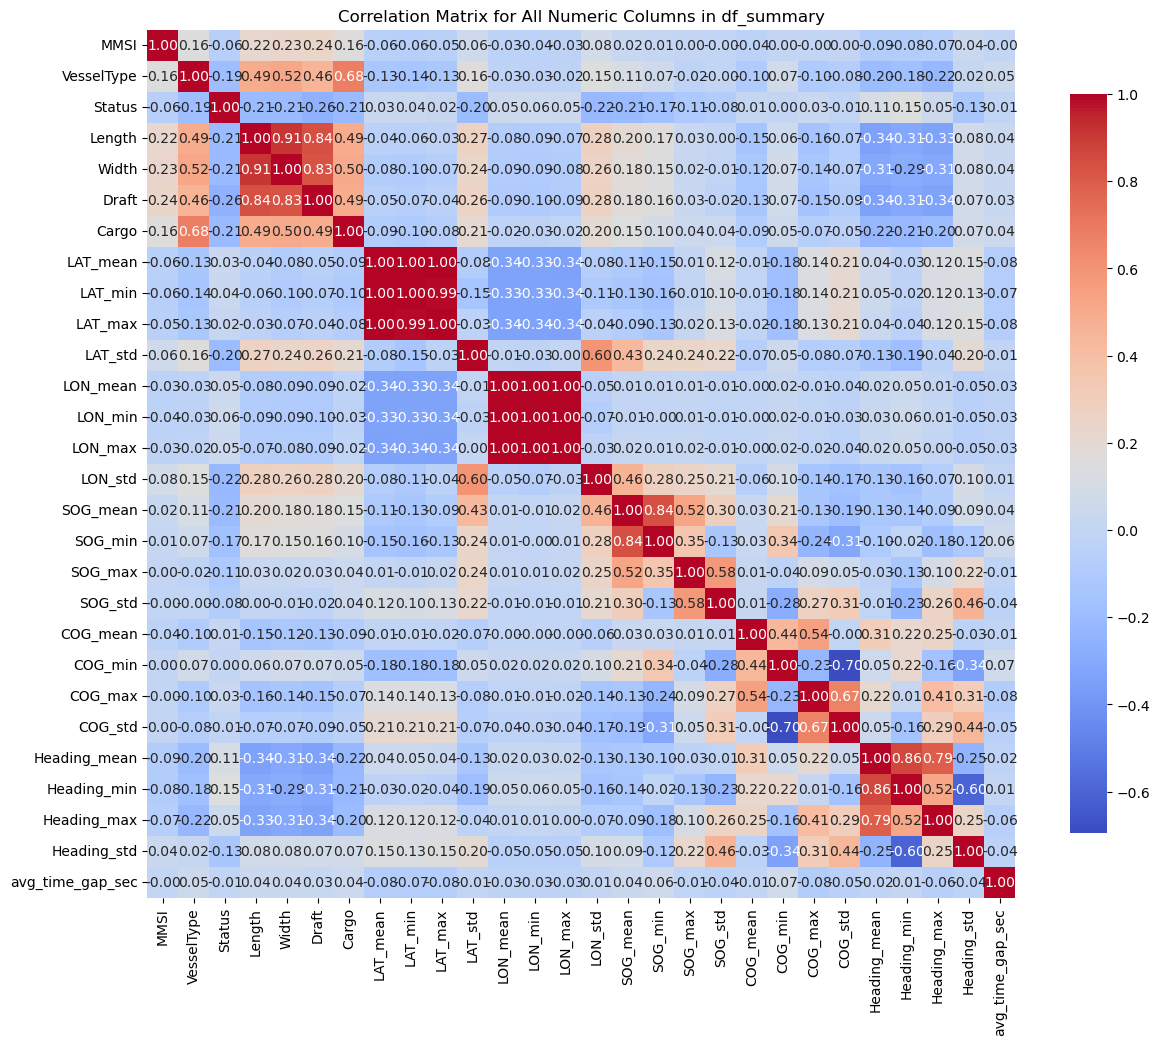

In [34]:
# Select only numeric columns
numeric_cols_all = df_summary.select_dtypes(include="number").columns

# Fill NaNs with 0 (or use mean imputation)
df_numeric = df_summary[numeric_cols_all].fillna(0)
# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix for All Numeric Columns in df_summary")
plt.show()

In [35]:
dummy_data = pd.read_csv('dummy_dataset.csv')

In [36]:
dummy_data

,MMSI,BaseDate,LAT,LON,SOG,COG,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,338075892,2024-01-01T00:00:00,42.36000,-70.670000,5.0,90,NaN,NaN,NaN
1,338075892,2024-01-01T00:00:01,42.36000,-70.668120,5.0,90,NaN,NaN,NaN
2,338075892,2024-01-01T00:00:02,42.36000,-70.666241,5.0,90,NaN,NaN,NaN
3,338075892,2024-01-01T00:00:03,42.36000,-70.664361,5.0,90,NaN,NaN,NaN
4,338075892,2024-01-01T00:00:04,42.36000,-70.662482,5.0,90,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
105,338075892,2024-01-01T00:00:05,58.30210,-134.396600,16.7,58,NaN,NaN,NaN
106,338075892,2024-01-01T00:00:06,58.30252,-134.395920,17.3,63,NaN,NaN,NaN
107,338075892,2024-01-01T00:00:07,58.30294,-134.395240,16.9,60,NaN,NaN,NaN
108,338075892,2024-01-01T00:00:08,58.30336,-134.394560,17.1,61,NaN,NaN,NaN


In [37]:
dummy_data['LAT_next'] = dummy_data.groupby('MMSI')['LAT'].shift(-1) 

# Handle circular COG
dummy_data['COG_sin'] = np.sin(np.deg2rad(dummy_data['COG'])) 
dummy_data['COG_cos'] = np.cos(np.deg2rad(dummy_data['COG'])) 

# Drop rows with NaNs created by shift(-1)
model_data = dummy_data[['LAT', 'SOG', 'COG_sin', 'COG_cos', 'LAT_next']].dropna()

X = model_data[['LAT', 'SOG', 'COG_sin', 'COG_cos']]
y = model_data['LAT_next']

# Add intercept
X = sm.add_constant(X)

# Fit linear regression
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               LAT_next   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1478.
Date:                Tue, 27 Jan 2026   Prob (F-statistic):           1.35e-84
Time:                        09:33:38   Log-Likelihood:                -186.80
No. Observations:                 100   AIC:                             383.6
Df Residuals:                      95   BIC:                             396.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3597      0.679     -0.530      0.597      -1.708       0.988
LAT            1.0119      0.015     67.543      0.000       0.982       1.042
SOG           -0.0122      0.024     -0.505      0.615      -0.060       0.036
COG_sin        0.4569      0.491      0.930      0.355      -0.518       1.432
COG_cos       -0.3459      0.484     -0.715      0.476      -1.306       0.614
==============================================================================
Omnibus:                      211.735   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35520.031
Skew:                           9.490   Prob(JB):                         0.00
Kurtosis:                      93.358   Cond. No.                         188.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\DJBird\AppData\Local\Temp\ipykernel_45828\245356033.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
C:\Users\DJBird\AppData\Local\Temp\ipykernel_45828\245356033.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1],


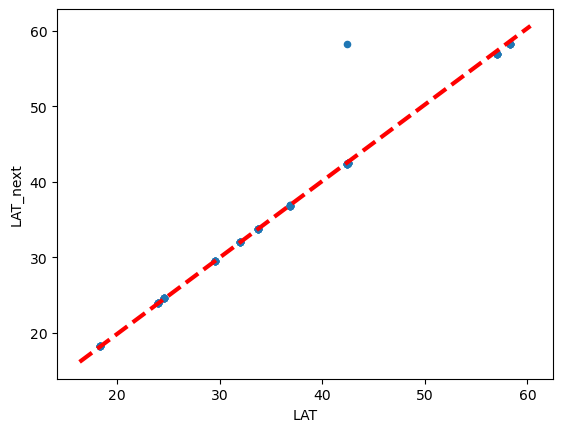

In [38]:
ax = dummy_data.plot.scatter('LAT', 'LAT_next')
abline(ax,
 results.params[0],
 results.params[1],
 'r--',
 linewidth=3)

In [39]:
dummy_data['LON_next'] = dummy_data.groupby('MMSI')['LON'].shift(-1) 

# Handle circular COG
dummy_data['COG_sin'] = np.sin(np.deg2rad(dummy_data['COG'])) 
dummy_data['COG_cos'] = np.cos(np.deg2rad(dummy_data['COG'])) 

# Drop rows with NaNs created by shift(-1)
model_data = dummy_data[['LON', 'SOG', 'COG_sin', 'COG_cos', 'LON_next']].dropna()

X = model_data[['LON', 'SOG', 'COG_sin', 'COG_cos']]
y = model_data['LON_next']

# Add intercept
X = sm.add_constant(X)

# Fit linear regression
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               LON_next   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1801.
Date:                Tue, 27 Jan 2026   Prob (F-statistic):           1.31e-88
Time:                        09:33:39   Log-Likelihood:                -325.72
No. Observations:                 100   AIC:                             661.4
Df Residuals:                      95   BIC:                             674.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3975      1.905     -0.209      0.835      -4.179       3.384
LON            0.9980      0.012     82.074      0.000       0.974       1.022
SOG            0.0686      0.094      0.727      0.469      -0.119       0.256
COG_sin       -1.8540      1.973     -0.940      0.350      -5.771       2.063
COG_cos        0.6962      1.729      0.403      0.688      -2.736       4.128
==============================================================================
Omnibus:                      212.827   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36444.154
Skew:                          -9.581   Prob(JB):                         0.00
Kurtosis:                      94.539   Cond. No.                         333.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\DJBird\AppData\Local\Temp\ipykernel_45828\2441118218.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
C:\Users\DJBird\AppData\Local\Temp\ipykernel_45828\2441118218.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1],


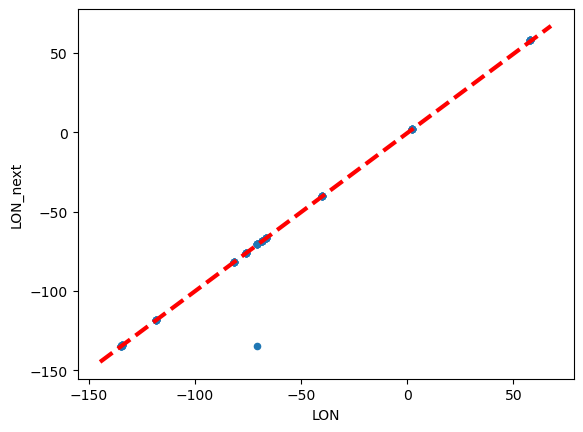

In [40]:
ax = dummy_data.plot.scatter('LON', 'LON_next')
abline(ax,
 results.params[0],
 results.params[1],
 'r--',
 linewidth=3)

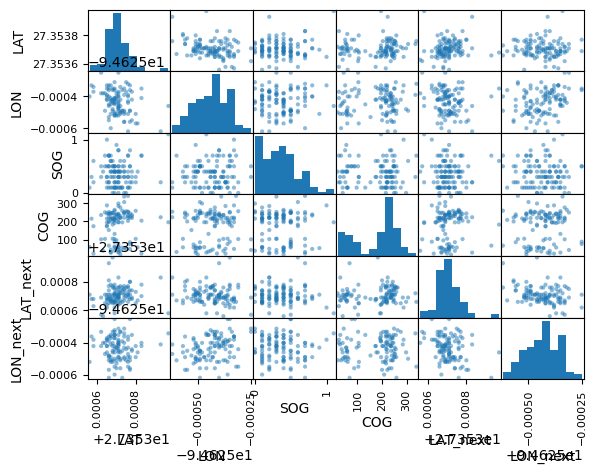

In [81]:
plot_data = ais_data[['LAT','LON','SOG','COG','LAT_next','LON_next']].dropna()
pd.plotting.scatter_matrix(plot_data[:110]);

In [57]:
plot_data.corr()

,LAT,LON,SOG,COG,LAT_next,LON_next
LAT,1.000000,-0.349937,-0.052950,0.003682,0.999841,-0.349942
LON,-0.349937,1.000000,-0.002939,-0.013028,-0.349938,0.999973
SOG,-0.052950,-0.002939,1.000000,0.019925,-0.052792,-0.002971
COG,0.003682,-0.013028,0.019925,1.000000,0.003706,-0.013081
LAT_next,0.999841,-0.349938,-0.052792,0.003706,1.000000,-0.349937
LON_next,-0.349942,0.999973,-0.002971,-0.013081,-0.349937,1.000000


# KNN Regression

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [62]:
features = ['LAT', 'SOG', 'COG_sin', 'COG_cos']

model_data = ais_data[features + ['LAT_next']].dropna()

X = model_data[features].values
y = model_data['LAT_next'].values


In [63]:
# ---- Train / test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=111
)

In [64]:
knns = [KNeighborsRegressor(n_neighbors = i) for i in range(1,20)]

fits = [knns[i].fit(X_train, y_train) for i in range(19)]

In [65]:
# R^2
k_values = range(1,20)
list_of_dicts = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
     # Metrics
    r2_train = knn.score(X_train, y_train)
    r2_test = knn.score(X_test, y_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    print(f"k={k}: R²(train)={r2_train:.3f}, R²(test)={r2_test:.5f}, "
          f"MSE(train)={mse_train:.3f}, MSE(test)={mse_test:.3f}")
    list_of_dicts.append({"k":k, "r2_train":r2_train, "r2_test": r2_test, "mse_train": mse_train, "mse_test": mse_test})

df = pd.DataFrame.from_dict(list_of_dicts)

k=1: R²(train)=1.000, R²(test)=0.99943, MSE(train)=0.003, MSE(test)=0.035
k=2: R²(train)=1.000, R²(test)=0.99957, MSE(train)=0.010, MSE(test)=0.026
k=3: R²(train)=1.000, R²(test)=0.99961, MSE(train)=0.012, MSE(test)=0.024
k=4: R²(train)=1.000, R²(test)=0.99964, MSE(train)=0.014, MSE(test)=0.023
k=5: R²(train)=1.000, R²(test)=0.99965, MSE(train)=0.015, MSE(test)=0.022
k=6: R²(train)=1.000, R²(test)=0.99966, MSE(train)=0.016, MSE(test)=0.021
k=7: R²(train)=1.000, R²(test)=0.99966, MSE(train)=0.016, MSE(test)=0.021
k=8: R²(train)=1.000, R²(test)=0.99967, MSE(train)=0.016, MSE(test)=0.021
k=9: R²(train)=1.000, R²(test)=0.99967, MSE(train)=0.017, MSE(test)=0.020
k=10: R²(train)=1.000, R²(test)=0.99967, MSE(train)=0.017, MSE(test)=0.020
k=11: R²(train)=1.000, R²(test)=0.99967, MSE(train)=0.017, MSE(test)=0.020
k=12: R²(train)=1.000, R²(test)=0.99968, MSE(train)=0.017, MSE(test)=0.020
k=13: R²(train)=1.000, R²(test)=0.99968, MSE(train)=0.017, MSE(test)=0.020
k=14: R²(train)=1.000, R²(test)=0.

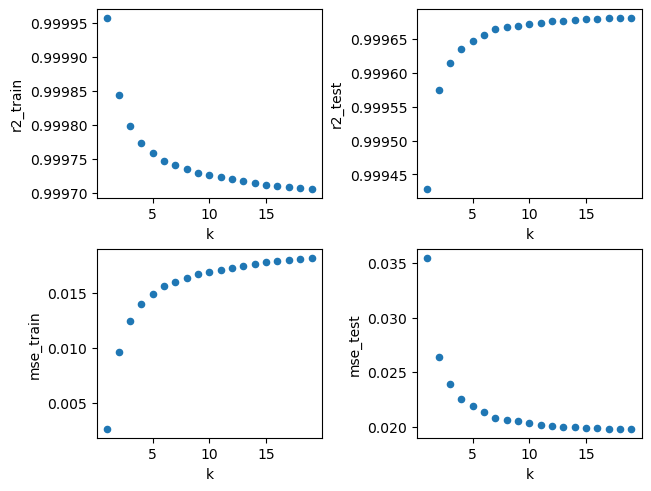

In [66]:
fig, axs = plt.subplots(2,2, layout = 'constrained');
df.plot.scatter('k', 'r2_train', ax = axs[0,0]);
df.plot.scatter('k', 'r2_test', ax = axs[0,1]);
df.plot.scatter('k', 'mse_train', ax = axs[1,0]);
df.plot.scatter('k', 'mse_test', ax = axs[1,1]);

## Decision Tree Regression

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [68]:
features = ['LAT', 'SOG', 'COG_sin', 'COG_cos']

model_data = ais_data[features + ['LAT_next']].dropna()

In [69]:
X = model_data[features].values
y = model_data['LAT_next'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,        # 30% test
    random_state=42,      # reproducibility
)

In [70]:
# Range of tree depths to test
depths = range(1, 11)
train_mse = []
test_mse = []

In [71]:
# Train and evaluate for each depth
for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_mse.append(mean_squared_error(y_train, y_pred_train))
    test_mse.append(mean_squared_error(y_test, y_pred_test))

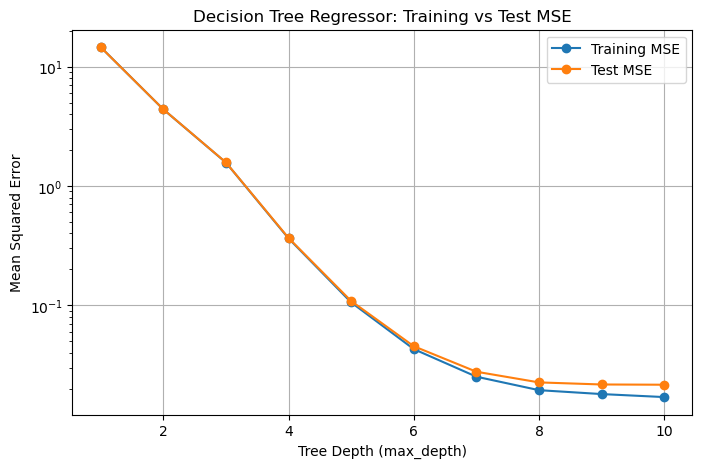

In [77]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(depths, train_mse, "o-", label="Training MSE")
plt.plot(depths, test_mse, "o-", label="Test MSE")
plt.xlabel("Tree Depth (max_depth)")
plt.ylabel("Mean Squared Error")
plt.yscale("log")
plt.title("Decision Tree Regressor: Training vs Test MSE")
plt.legend()
plt.grid(True)
plt.show()

In [73]:
best_tree = DecisionTreeRegressor(max_depth=6, random_state=42)
best_tree.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


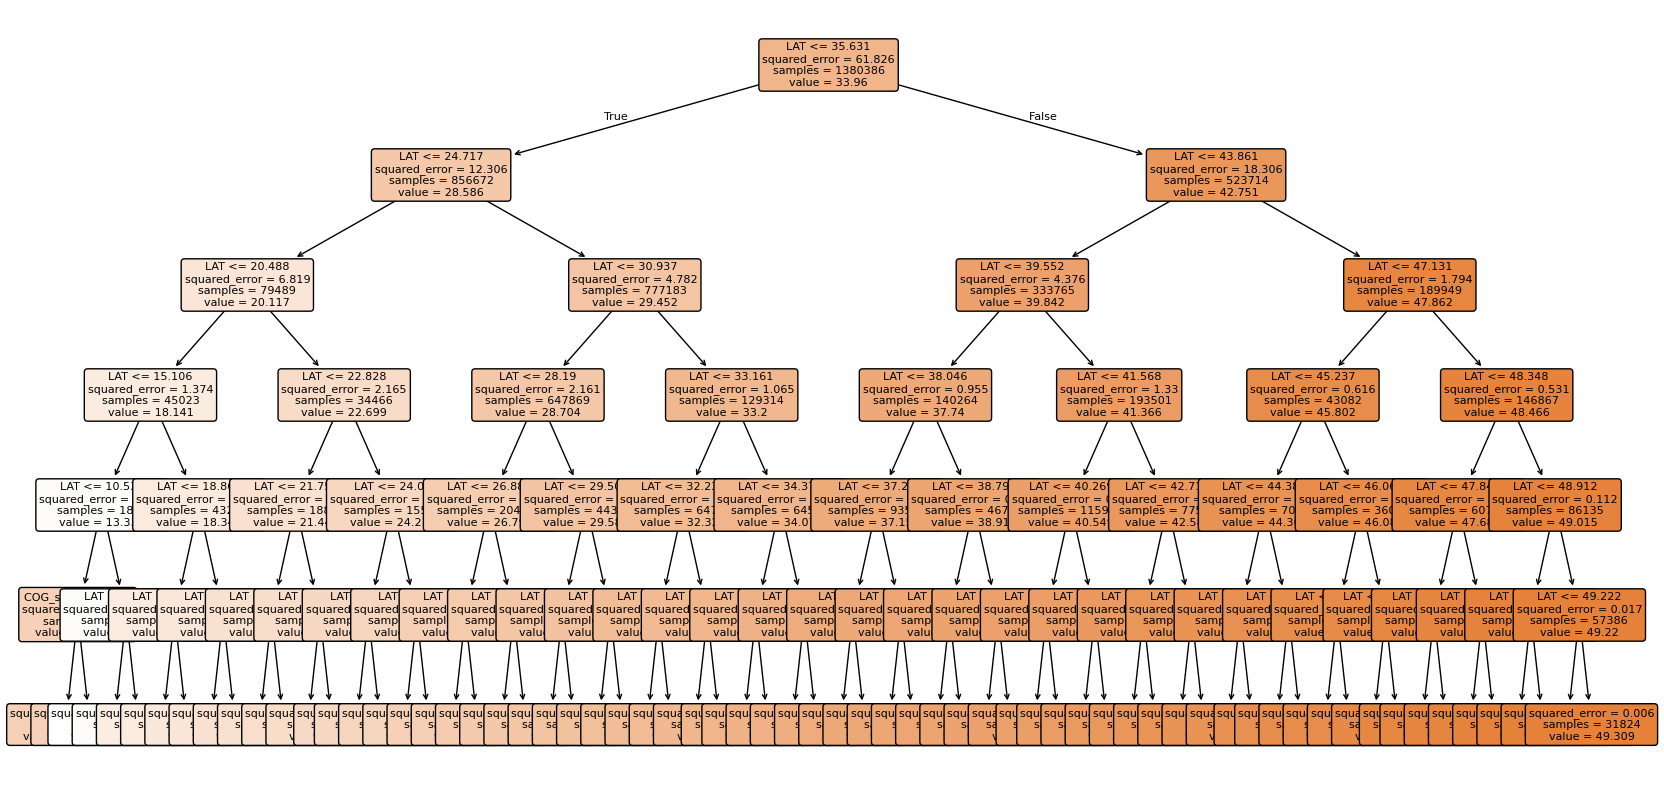

In [79]:
plt.figure(figsize=(20, 10))
plot_tree(best_tree,
          feature_names=features,
          filled=True,
          rounded=True,
          fontsize=8)
plt.savefig("ais_data_matplotlib.pdf")  # saves PDF in current directory
plt.show()